subject_id: 323 Eval ; time: 135.4165263926649 



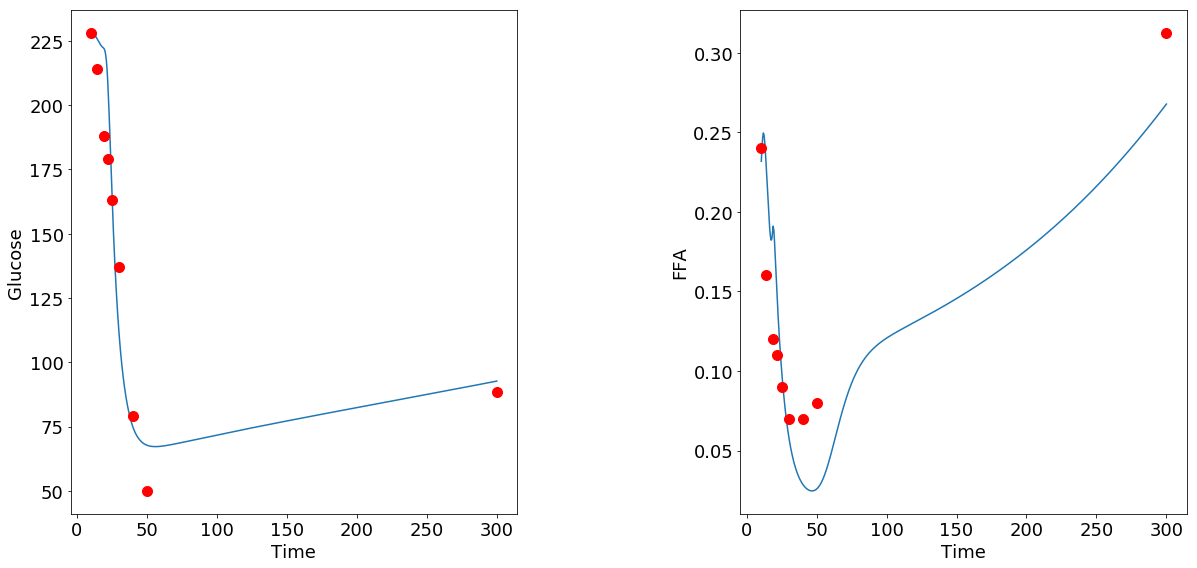

In [3]:
%matplotlib inline
import os
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import scipy.sparse
import scipy.linalg
from chung_cpep_secretion import parameters
import timeit

def interp(t_obs,f_obs,h=0.5):
    T = t_obs[-1]-t_obs[0]
    T_f=t_obs[-1]
#    print(T,t_obs[-1],t_obs[0])
    n = int(np.floor(T/h-1))
#    print("n", n)
    t = np.arange(t_obs[0]+h,T_f+h,h)
#    print(t[:4],t[-3:])
    time_indices = [np.argwhere(np.abs(t-time)<1e-8)[0,0] for time in t_obs if time>t_obs[0]]
#    print len(time_indices),len(t_obs)
    projection = np.eye(n+1)[time_indices]
    e = np.ones(n+1)
    F = sp.sparse.spdiags([1*e,-4*e,3*e],[-2,-1,0],n+1,n+1).todense()/2/h
    F[0,0],F[0,1]=-1/h,0.5/h
    F[1,0],F[1,1],F[1,2]=-.8/h,.6/h,.2/h
    invert = np.linalg.inv(np.dot(np.dot(projection,np.linalg.inv(np.dot(F.T,F))),projection.T))
    total = np.dot(np.dot(np.linalg.inv(np.dot(F.T,F)),projection.T),invert)
    return t,f_obs[0]+np.array(np.dot(total,f_obs[1:]-f_obs[0]).T).reshape(n+1)

def fat_func_maker(par):
    l0 = par[0]
    l2 = par[1]
    x2 = par[2]
    cf = par[3]
    xcl = par[4]
    def lipo_func(x_try):
        return l0 + l2/(1+(x_try/x2)**2)
    def clear_func(x_try):
        y = (x_try/xcl)**2
        return cf*(1.0 + y/(1+y))
    return lipo_func,clear_func

def xf(parx,ins_interp,h=0.5):
    cx = parx[0]
    Ibx = parx[1]
    n = np.shape(ins_interp)[0]
    e = np.ones(n)
    F = sp.sparse.spdiags([1*e,-4*e,3*e],[-2,-1,0],n,n).todense()/2/h
    F[0,0],F[0,1]=-1/h,0.5/h
    F[1,0],F[1,1],F[1,2]=-.8/h,.6/h,.2/h
    F = F + cx*np.diag(e)
    x = np.dot(np.linalg.inv(F),cx*(ins_interp-Ibx)).reshape(ins_interp.shape)
    x = np.maximum(x,np.zeros(n))
    return np.array(x).reshape(ins_interp.shape)

def ff(par,f_init,x,h=0.5):
    lip_fun,clear_fun = fat_func_maker(par)
    n = np.shape(x)[0]-1
    e = np.ones(n+1)
    F = sp.sparse.spdiags([1*e,-4*e,3*e],[-2,-1,0],n+1,n+1).todense()/2/h
    F[0,0],F[0,1]=-1/h,0.5/h
    F[1,0],F[1,1],F[1,2]=-.8/h,.6/h,.2/h
    F = F + np.diag(clear_fun(x))
    f= np.maximum(np.dot(np.linalg.inv(F),(lip_fun(x)-f_init*clear_fun(x))).reshape(x.shape)+f_init,np.zeros(n+1))
##    plt.plot(np.arange(n+1),f.T)
##    plt.show()
    return np.array(f).reshape(x.shape)
    
def gf(parg,g_init,x,h=0.5):
    sg = parg[0]
    si = parg[1]
    gb = parg[2]
    n = np.shape(x)[0]-1
    e = np.ones(n+1)
    F = sp.sparse.spdiags([1*e,-4*e,3*e],[-2,-1,0],n+1,n+1).todense()/2/h
    F[0,0],F[0,1]=-1/h,0.5/h
    F[1,0],F[1,1],F[1,2]=-.8/h,.6/h,.2/h
    F = F + np.diag((sg+si*x))
    g = np.maximum(np.dot(np.linalg.inv(F),(sg*(gb-g_init)-si*x*g_init)).reshape(x.shape)+g_init,np.zeros(n+1))
##    plt.plot(np.arange(n+1),g.T)
##    plt.show()
    return np.array(g).reshape(x.shape)

location=os.getcwd()
counter=0
i=11

file=r'323 Eval 7.24.18.xlsx'
start = timeit.default_timer()
df = pd.read_excel(file)
subject_id = file.split()[0]
index = file.split()[1]
if any(isinstance(x, str) for x in df['Time'][i:24]) == True or \
any(isinstance(x, str) for x in df['Glucose (mg/dL)'][i:24]) == True or \
any(isinstance(x, str) for x in df['Insulin (uU/mL)'][i:24]) == True or \
any(isinstance(x, str) for x in df['C-peptide (ng/mL)'][i:24]) == True or \
any(isinstance(x, str) for x in df['FFA (mEq/L)'][i:24]) == True:
    print('There is a string in the %s' % file)
Time = (df['Time'][i:24].values).astype(dtype='float64')
Glucose = (df['Glucose (mg/dL)'][i:24].values).astype(dtype='float64')
Insulin = (df['Insulin (uU/mL)'][i:24].values).astype(dtype='float64')
C = (df['C-peptide (ng/mL)'][i:24].values).astype(dtype='float64')
F = (df['FFA (mEq/L)'][i:24].values).astype(dtype='float64')
num_data = np.vstack((Time, Glucose, Insulin, C, F)).T
num_data = np.delete(num_data, np.where(num_data == np.float64(-1))[0], axis=0)
par = parameters(num_data)[1]
stop = timeit.default_timer()
print('subject_id:', subject_id, index, ';', 'time:', (stop-start)/60, '\n')

# par=[0.05247565469124646, 3.063593299403137, 0.003223068493767309, 0.02351359245224254, 10.688346843333525, 0.029969398336352537, 1.4992601561005614, 0.008009969733666529, 7.648769164230966e-05, 67.13424939851188]
t_obs = num_data[:,0]
g_obs = num_data[:,1]
i_obs = num_data[:,2]
c_obs = num_data[:,3]
f_obs = num_data[:,4]
t_interp,ins = interp(t_obs,i_obs)

h=0.5
T = t_obs[-1]-t_obs[1]
T_f=t_obs[-1]
n = int(np.floor(T/h-1))
t = np.arange(t_obs[0]+h,T_f+h,h)
parx = par[:2]
parf = par[2:7]
parg = par[7:10]
x = xf(parx,ins)
f = ff(parf,f_obs[0],x)
g = gf(parg,g_obs[0],x)

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'lines.markersize':10})
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
plt.subplots_adjust(wspace=0.5, bottom=0.18)

ax1.plot(t, g)
ax1.plot(t_obs, g_obs, 'ro')
ax1.set_xlabel('Time')
ax1.set_ylabel('Glucose')

ax2.plot(t, f)
ax2.plot(t_obs, f_obs, 'ro')
ax2.set_xlabel('Time')
ax2.set_ylabel('FFA')

# fig.savefig('EPS/%s_%s.eps' % (subject_id, index))
plt.show()


# for file in os.listdir(location):
#     if file[0].isdigit() == True and file.endswith('.xlsx'):
#         start = timeit.default_timer()
#         df = pd.read_excel(file)
#         subject_id = file.split()[0]
#         index = file.split()[1]
#         if any(isinstance(x, str) for x in df['Time'][i:23]) == True or \
#         any(isinstance(x, str) for x in df['Glucose (mg/dL)'][i:23]) == True or \
#         any(isinstance(x, str) for x in df['Insulin (uU/mL)'][i:23]) == True or \
#         any(isinstance(x, str) for x in df['C-peptide (ng/mL)'][i:23]) == True or \
#         any(isinstance(x, str) for x in df['FFA (mEq/L)'][i:23]) == True:
#             print('There is a string in the %s' % file)
#             continue
#         Time = (df['Time'][i:23].values).astype(dtype='float64')
#         Glucose = (df['Glucose (mg/dL)'][i:23].values).astype(dtype='float64')
#         Insulin = (df['Insulin (uU/mL)'][i:23].values).astype(dtype='float64')
#         C = (df['C-peptide (ng/mL)'][i:23].values).astype(dtype='float64')
#         F = (df['FFA (mEq/L)'][i:23].values).astype(dtype='float64')
#         num_data = np.vstack((Time, Glucose, Insulin, C, F)).T
#         num_data = np.delete(num_data, np.where(num_data == np.float64(-1))[0], axis=0)
#         par = parameters(num_data)[1]
#         stop = timeit.default_timer()
#         print('subject_id:', subject_id, index, ';', 'time:', (stop-start)/60, '\n')
        
#         t_obs = num_data[:,0]
#         g_obs = num_data[:,1]
#         i_obs = num_data[:,2]
#         c_obs = num_data[:,3]
#         f_obs = num_data[:,4]
#         t_interp,ins = interp(t_obs,i_obs)

#         h=0.5
#         T = t_obs[-1]-t_obs[0]
#         T_f=t_obs[-1]
#         n = int(np.floor(T/h-1))
#         t = np.arange(t_obs[0]+h,T_f+h,h)
#         parx = par[:2]
#         parf = par[2:7]
#         parg = par[7:10]
#         x = xf(parx,ins)
#         f = ff(parf,f_obs[0],x)
#         g = gf(parg,g_obs[0],x)

#         fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
#         plt.subplots_adjust(wspace=0.5, bottom=0.18)

#         ax1.plot(t, g)
#         ax1.plot(t_obs, g_obs, 'ro')
#         ax1.set_xlabel('Time')
#         ax1.set_ylabel('Glucose')
        
#         ax2.plot(t, f)
#         ax2.plot(t_obs, f_obs, 'ro')
#         ax2.set_xlabel('Time')
#         ax2.set_ylabel('FFA')
        
#         fig.savefig('EPS/%s_%s_partial.eps' % (subject_id, index))
#         plt.close(fig)